### (LCB) Lower Confidence Bound Acquisition

In [1]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import pandas as pd
from pyomo.environ import *
from GPy.kern import RBF
from GPy.kern import Matern52
from GPy.kern import Linear
from datetime import datetime
import time
import os
import textwrap
import re
import inspect
import matplotlib.pyplot as plt

In [2]:
start_time = datetime.fromtimestamp(time.time())

data_path = r'DataSet\siouxdata\\'

candid = pd.read_excel(data_path + 'candidpoint.xlsx', sheet_name='Sheet1')
deltalink = pd.read_excel(data_path + 'deltalinksioux.xlsx', sheet_name='Sheet1')
facilitycap = pd.read_excel(data_path + 'capfacsioux.xlsx', sheet_name='Sheet1')
nodedem = pd.read_excel(data_path + 'demandsioux.xlsx', sheet_name='Sheet1')
linkcap = pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')
linkfreecost = pd.read_excel(data_path + 'freeflownsioux.xlsx', sheet_name='Sheet1')
qod = pd.read_excel(data_path + 'xodsioux.xlsx', sheet_name='Sheet1')   
numod = pd.read_excel(data_path + 'numodsioux.xlsx', sheet_name='Sheet1')
deltaod = pd.read_excel(data_path + 'deltaodsioux.xlsx', sheet_name='Sheet1')
fixedfacility = pd.read_excel(data_path + 'fixedcostsioux.xlsx', sheet_name='Sheet1')
capincreas=0.1 * pd.read_excel(data_path + 'caplinknsioux.xlsx', sheet_name='Sheet1')

end_time = datetime.fromtimestamp(time.time())

# --- Stop conditions
# max_time  = 1000
max_iter  = 150
# tolerance = 0 #1e-2

print('Total time for read data: ', end_time - start_time)

Total time for read data:  0:00:04.171512


In [3]:
[numlink,numpath]=np.shape(deltalink)
(a,numfacility)=np.shape(facilitycap)
(b,numcustomer)=np.shape(nodedem)
# sets
Model.setpath = range(numpath)
Model.setfacility = range(numfacility)
Model.setcustomer = range(numcustomer)
Model.setlink = range(numlink)
print('numpath', numpath, '\nnumlink: ', numlink, '\nnumfacility: ', numfacility)

numpath 940 
numlink:  100 
numfacility:  12


In [4]:
def objfunc2d(x):
    
    Model = AbstractModel()
    xe=np.zeros(([1,numlink]))
    y=np.zeros(([1,numfacility]))
    for k in Model.setlink:
        xe[0,k]=x[:,k]
            
    print(xe)
    Model._fprimrsk = Var(Model.setpath,within=NonNegativeReals)
    Model._ve = Var(Model.setlink,within=NonNegativeReals)
    
    def fobjective(Model):
        return sum(linkfreecost.iloc[0,e]*(Model._ve[e]+0.15*Model._ve[e]**5/
                                               (5*((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)
    Model.obj = Objective(rule=fobjective,sense=minimize)

    def cons4(Model,r,s):
        return sum(Model._fprimrsk[k]*deltaod.iloc[numod.iloc[r,s]-1,k]  for k in Model.setpath)==qod.iloc[r,s]
    Model.con4 = Constraint(Model.setcustomer,Model.setcustomer,rule=cons4)
 
    def cons5(Model,e):
        return sum((Model._fprimrsk[k])*deltalink.iloc[e,k]  for k in Model.setpath) ==Model._ve[e]
    Model.con5=Constraint(Model.setlink,rule=cons5) 
        
    NTA0 = Model.create_instance()
    
    opt = SolverFactory('ipopt')
    opt.solve(NTA0)
    return sum(linkfreecost.iloc[0,e]*(1*NTA0._ve[e].value+0.15*NTA0._ve[e].value**5/
                                               (((linkcap.iloc[0,e]+xe[0,e]*capincreas.iloc[0,e])**4))) for e in Model.setlink)

## Here define constraints into function

In [5]:
def constraint_to_string(constraint_function):
    source_code = inspect.getsource(constraint_function)    
    source_code = textwrap.dedent(source_code)    
    constraint_expression = re.search(r'return\s+(.*)(\s)*$', source_code, re.MULTILINE).group(1)    
    return constraint_expression

bounds = [{'name': 'xe', 'type': 'discrete', 'domain': (0,1), 'dimensionality':numlink}]

## Matern kernel 35

In [6]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 35

constraint_string = constraint_to_string(budget_constraint)
constraints35 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [7]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints35) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
matern_kernel=Matern52(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=matern_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (LCB) acquisition
acquisition = GPyOpt.acquisitions.LCB.AcquisitionLCB(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_matern35 = GPyOpt.methods.ModularBayesianOptimization(model,feasible_region,objective,acquisition,evaluator,initial_design)

# Run the optimization
bo_matern35.run_optimization(max_iter=max_iter, verbosity=False)

end_time = datetime.fromtimestamp(time.time())
print('Total time for matern kernel 35 edges: ', end_time - start_time)

[[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
  1. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.

[[0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  1. 0. 0. 1.]]
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
  1. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0.]]
[[1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.

[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
  0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 0. 1.]]
[[0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.

[[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 0.]]
[[1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
  1. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.

[[0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0.]]
[[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.

[[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
  0. 1. 0. 0.]]
[[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1.]]
[[0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.

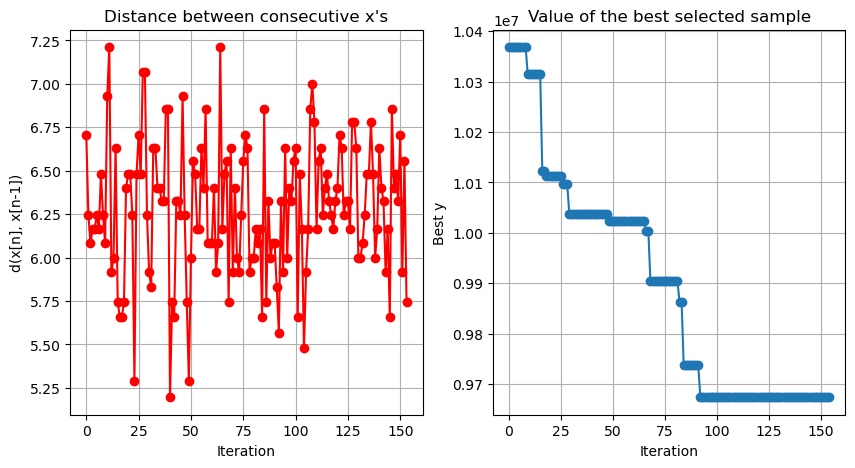

In [8]:
bo_matern35.plot_convergence()

In [9]:
print(bo_matern35.x_opt)
print(bo_matern35.fx_opt)
bo_matern35.Y_best

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 0.]
9673957.763815934


array([10368177.27622261, 10368177.27622261, 10368177.27622261,
       10368177.27622261, 10368177.27622261, 10368177.27622261,
       10368177.27622261, 10368177.27622261, 10368177.27622261,
       10314227.57979783, 10314227.57979783, 10314227.57979783,
       10314227.57979783, 10314227.57979783, 10314227.57979783,
       10314227.57979783, 10123174.66196944, 10123174.66196944,
       10111950.01743249, 10111950.01743249, 10111950.01743249,
       10111950.01743249, 10111950.01743249, 10111950.01743249,
       10111950.01743249, 10111950.01743249, 10097275.34942346,
       10097275.34942346, 10097275.34942346, 10036627.21782786,
       10036627.21782786, 10036627.21782786, 10036627.21782786,
       10036627.21782786, 10036627.21782786, 10036627.21782786,
       10036627.21782786, 10036627.21782786, 10036627.21782786,
       10036627.21782786, 10036627.21782786, 10036627.21782786,
       10036627.21782786, 10036627.21782786, 10036627.21782786,
       10036627.21782786, 10036627.21782

## Matern kernel 40

In [10]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 40

constraint_string = constraint_to_string(budget_constraint)
constraints40 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [11]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints40) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
matern_kernel=Matern52(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=matern_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (LCB) acquisition
acquisition = GPyOpt.acquisitions.LCB.AcquisitionLCB(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_matern40 = GPyOpt.methods.ModularBayesianOptimization(model,feasible_region,objective,acquisition,evaluator,initial_design)

# Run the optimization
bo_matern40.run_optimization(max_iter=max_iter, verbosity=False)

end_time = datetime.fromtimestamp(time.time())
print('Total time for matern kernel 40 edges: ', end_time - start_time)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
  1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 1. 1.]]
[[1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
  1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
  1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 0.]]
[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.

[[0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  1. 1. 0. 0.]]
[[1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
  1. 1. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
  0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 1. 1. 0.]]
[[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.

[[1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
  0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
  0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  1. 0. 1. 0.]]
[[1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
  1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0.]]
[[1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  0. 1. 1. 1.]]
[[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.

[[1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0.
  0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 1.]]
[[0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.

[[1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0.
  0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
  1. 1. 0. 0.]]
[[0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 1.]]
[[1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
  0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
  1. 0. 0. 1.]]
[[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.

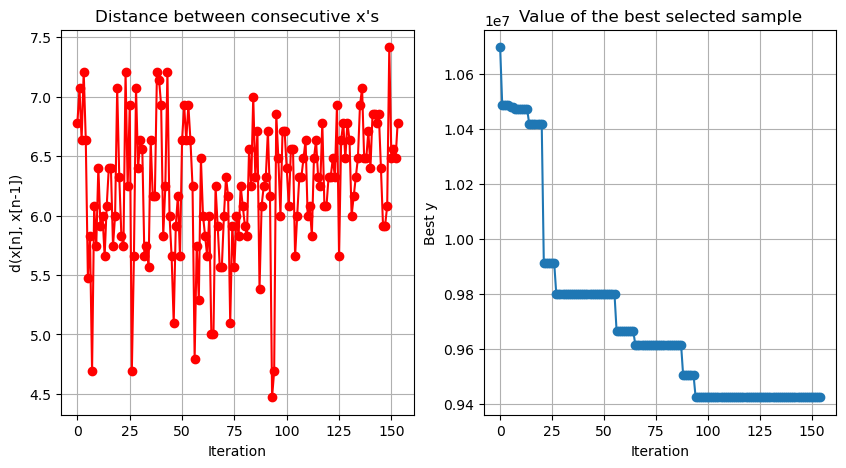

In [12]:
bo_matern40.plot_convergence()

In [13]:
print(bo_matern40.x_opt)
print(bo_matern40.fx_opt)
bo_matern40.Y_best

[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0.]
9423053.011590939


array([10695672.08543308, 10486753.61376294, 10486753.61376294,
       10486753.61376294, 10486753.61376294, 10477355.19001666,
       10477355.19001666, 10469875.18908467, 10469875.18908467,
       10469875.18908467, 10469875.18908467, 10469875.18908467,
       10469875.18908467, 10469875.18908467, 10415427.82281754,
       10415427.82281754, 10415427.82281754, 10415427.82281754,
       10415427.82281754, 10415427.82281754, 10415427.82281754,
        9911092.14277533,  9911092.14277533,  9911092.14277533,
        9911092.14277533,  9911092.14277533,  9911092.14277533,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769328,  9797289.07769328,
        9797289.07769328,  9797289.07769

## Matern kernel 45

In [14]:
# Budget constraint function
def budget_constraint(x):
    return sum(x[:, e] for e in range(100)) - 45

constraint_string = constraint_to_string(budget_constraint)
constraints45 = [{'name': 'budget_con', 'constraint': constraint_string}]

In [15]:
start_time = datetime.fromtimestamp(time.time())

#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space=bounds, constraints=constraints45) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)
matern_kernel=Matern52(input_dim=100)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objfunc2d)

# CHOOSE the model type
model = GPyOpt.models.GPModel(kernel=matern_kernel, exact_feval=True, optimize_restarts=5, verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of (LCB) acquisition
acquisition = GPyOpt.acquisitions.LCB.AcquisitionLCB(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Create BO object
bo_matern45 = GPyOpt.methods.ModularBayesianOptimization(model,feasible_region, objective,acquisition,evaluator, initial_design)

# Run the optimization                                                  
bo_matern45.run_optimization(max_iter=max_iter, verbosity=False)

end_time = datetime.fromtimestamp(time.time())
print('Total time for matern kernel 45 edges: ', end_time - start_time)

[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
  1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
  0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
  1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
  1. 0. 1. 0.]]
[[1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
  1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 1. 0.]]
[[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
  1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 1. 0.]]
[[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.

[[0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
  1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
  1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
  1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 1. 1.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0.
  1. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0.
  1. 1. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  1. 1. 0. 0.]]
[[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.
  1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
  0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
  1. 0. 0. 0.]]
[[0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.

[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
  0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0.
  1. 1. 1. 1.]]
[[1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
  1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
  1. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0.
  1. 1. 0. 1.]]
[[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.

[[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
  0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0.
  1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
  1. 1. 0. 0.]]
[[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 1. 0. 1.]]
[[0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
  1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
  1. 1. 0. 1.]]
[[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.

[[0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 1. 0. 0.]]
[[0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
  0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0.
  1. 0. 0. 0.]]
[[0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
  0. 1. 0. 1.]]
[[0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.

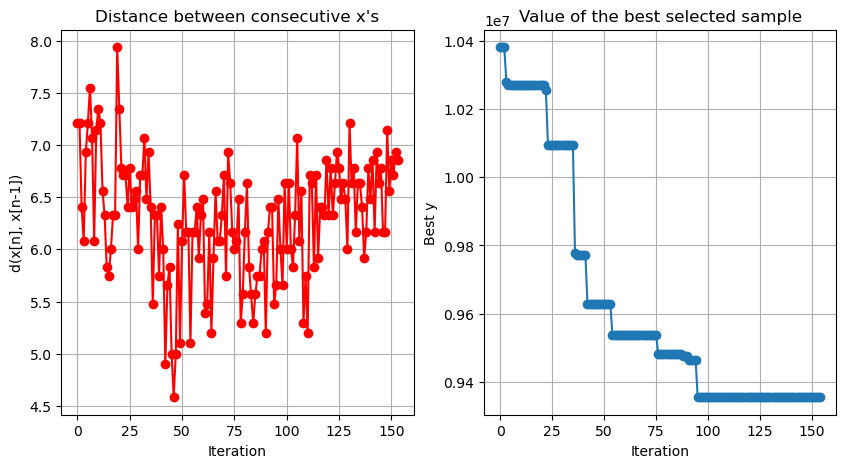

In [16]:
bo_matern45.plot_convergence()

In [17]:
print(bo_matern45.x_opt)
print(bo_matern45.fx_opt)
bo_matern45.Y_best

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 0. 0.]
9355044.172143023


array([10381361.90138854, 10381361.90138854, 10381361.90138854,
       10279237.85898572, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10270239.54892658, 10270239.54892658,
       10270239.54892658, 10255162.21639334, 10093376.895908  ,
       10093376.895908  , 10093376.895908  , 10093376.895908  ,
       10093376.895908  , 10093376.895908  , 10093376.895908  ,
       10093376.895908  , 10093376.895908  , 10093376.895908  ,
       10093376.895908  , 10093376.895908  , 10093376.895908  ,
        9776903.19556772,  9771877.25485439,  9771877.25485439,
        9771877.25485439,  9771877.25485439,  9771877.25485439,
        9628085.78067885,  9628085.78067885,  9628085.78067885,
        9628085.78067885,  9628085.78067

## Figure

In [18]:
print("Bayesian optimization function for 35 = ", bo_matern35.fx_opt,
      "\nBayesian optimization function for 40 = ", bo_matern40.fx_opt,
      "\nBayesian optimization function for 45 = ", bo_matern45.fx_opt)

Bayesian optimization function for 35 =  9673957.763815934 
Bayesian optimization function for 40 =  9423053.011590939 
Bayesian optimization function for 45 =  9355044.172143023


In [19]:
bayesian_optimization = [bo_matern35.fx_opt, bo_matern40.fx_opt, bo_matern45.fx_opt]
colors = ['red', 'blue', 'green']
selected_edges = [35, 40, 45]

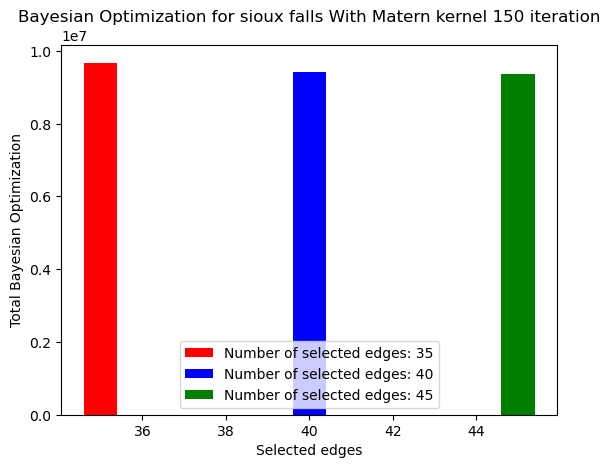

In [20]:
for i, (edges, bo_value) in enumerate(zip(selected_edges, bayesian_optimization)):
    plt.bar(edges, bo_value, color=colors[i], label=f'Number of selected edges: {edges}')
    
plt.xlabel('Selected edges')
plt.ylabel('Total Bayesian Optimization')
plt.title('Bayesian Optimization for sioux falls With Matern kernel 150 iteration')
plt.legend()
plt.show()

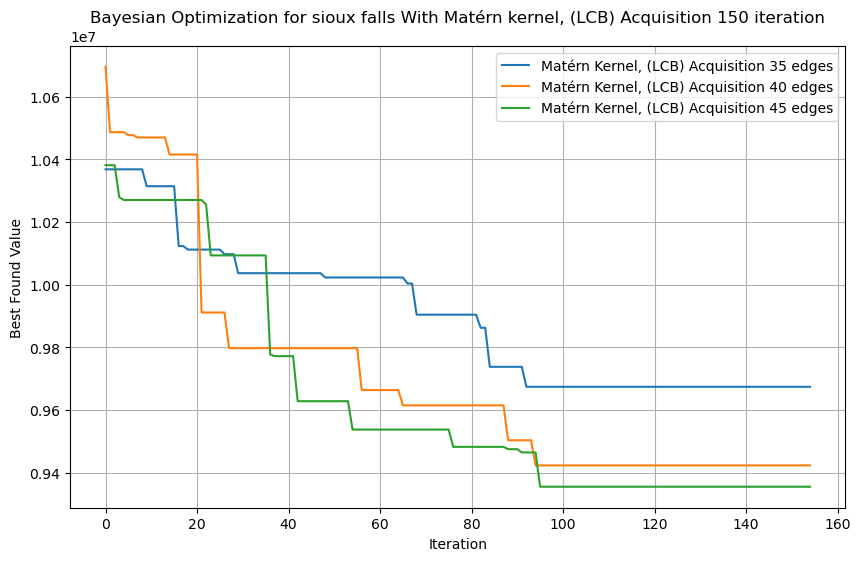

In [21]:
# Plot convergence data
plt.figure(figsize=(10, 6))
plt.plot(bo_matern35.Y_best, label='Matérn Kernel, (LCB) Acquisition 35 edges')
plt.plot(bo_matern40.Y_best, label='Matérn Kernel, (LCB) Acquisition 40 edges')
plt.plot(bo_matern45.Y_best, label='Matérn Kernel, (LCB) Acquisition 45 edges')

plt.xlabel('Iteration')
plt.ylabel('Best Found Value')
plt.title('Bayesian Optimization for sioux falls With Matérn kernel, (LCB) Acquisition 150 iteration')
plt.legend(loc='best')
plt.grid(True)
plt.show()

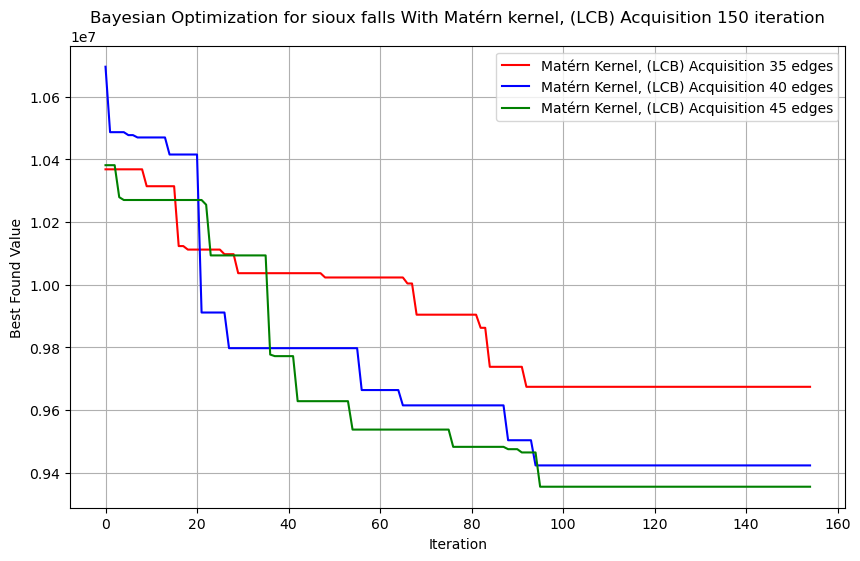

In [22]:
# Plot convergence data
plt.figure(figsize=(10, 6))
plt.plot(bo_matern35.Y_best, color='red', label='Matérn Kernel, (LCB) Acquisition 35 edges')
plt.plot(bo_matern40.Y_best, color='blue', label='Matérn Kernel, (LCB) Acquisition 40 edges')
plt.plot(bo_matern45.Y_best, color='green', label='Matérn Kernel, (LCB) Acquisition 45 edges')

plt.xlabel('Iteration')
plt.ylabel('Best Found Value')
plt.title('Bayesian Optimization for sioux falls With Matérn kernel, (LCB) Acquisition 150 iteration')
plt.legend(loc='best')
plt.grid(True)
plt.show()